In [1]:
import yfinance as yf
import pandas as pd
import requests
import pandas as pd
from datetime import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import socketserver
import json

In [2]:
##### READING HISTORICAL DATA GATHERED FROM API

total_data = pd.read_csv('/Users/yujata/RealTime_Final/Final/CitiesVF.csv')
total_data = pd.DataFrame(total_data)

total_data['date'] = pd.to_datetime(total_data['date'])
total_data


,date,datatype,value,city
0,2018-01-01,TAVG,259,CITY:BR000003
1,2018-01-01,TAVG,237,CITY:BR000003
2,2018-01-01,TAVG,238,CITY:BR000003
3,2018-01-02,TAVG,257,CITY:BR000003
4,2018-01-02,TAVG,238,CITY:BR000003
...,...,...,...,...
219513,2024-02-18,PRCP,0,CITY:CH000033
219514,2024-02-19,PRCP,0,CITY:CH000033
219515,2024-02-20,PRCP,203,CITY:CH000033
219516,2024-02-21,PRCP,10,CITY:CH000033


In [3]:
##### GETTING HISTORICAL DATA OF COMMODITIES OF INTEREST  FROM YAHOO FINANCE

def get_commodity_data(symbols, start_date, end_date):
    """
    Function to fetch historical commodity price data from Yahoo Finance.

    Parameters:
        symbols (list of str): Symbols of the commodities (e.g., ['GC=F', 'SI=F']).
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        DataFrame: Pandas DataFrame containing historical commodity price data.
    """
    try:
        # Initialize an empty DataFrame
        all_data = pd.DataFrame()

        # Fetch historical data for each symbol
        for symbol in symbols:
            data = yf.download(symbol, start=start_date, end=end_date)
            # Add a new column for the commodity symbol
            data['Commodity'] = symbol
            all_data = pd.concat([all_data, data])

        return all_data
    except Exception as e:
        print("An error occurred:", str(e))
        return None

# Example usage
if __name__ == "__main__":
    # Define commodity symbols (e.g., ['GC=F', 'SI=F' for Gold and Silver futures])
    commodity_symbols = ['KC=F', 'ZC=F', 'CT=F',  'ZR=F',  'ZS=F', 'SB=F', 'ZW=F']

    # Define start and end dates for data retrieval
    start_date = '2018-01-01'
    end_date = '2024-12-31'

    # Fetch commodity data
    commodity_data = get_commodity_data(commodity_symbols, start_date, end_date)

    # Display the fetched data
    if commodity_data is not None:
        print("Commodity data:")
        print(commodity_data)  # Display first few rows of the data
    else:
        print("Failed to fetch commodity data.")

# Check if data is fetched successfully
if commodity_data is not None:
    # Reset index to avoid index column in CSV
    commodity_data.reset_index(inplace=True)

    # Define the filename for the CSV file
    csv_filename = "commodity_data.csv"

    # Write the commodity data to the CSV file
    commodity_data.to_csv(csv_filename, index=False)

    print("CSV file created successfully:", csv_filename)
else:
    print("Failed to fetch commodity data.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Commodity data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  126.000000  130.649994  126.000000  130.199997  130.199997   
2018-01-03  130.000000  131.350006  126.199997  128.600006  128.600006   
2018-01-04  128.199997  129.649994  126.599998  129.550003  129.550003   
2018-01-05  129.199997  129.550003  127.900002  128.449997  128.449997   
2018-01-08  127.599998  127.650002  124.300003  125.15000

In [4]:
commodity_data = pd.DataFrame(commodity_data)
commodity_data

,Date,Open,High,Low,Close,Adj Close,Volume,Commodity
0,2018-01-02,126.000000,130.649994,126.000000,130.199997,130.199997,30181,KC=F
1,2018-01-03,130.000000,131.350006,126.199997,128.600006,128.600006,38733,KC=F
2,2018-01-04,128.199997,129.649994,126.599998,129.550003,129.550003,21987,KC=F
3,2018-01-05,129.199997,129.550003,127.900002,128.449997,128.449997,23119,KC=F
4,2018-01-08,127.599998,127.650002,124.300003,125.150002,125.150002,32165,KC=F
...,...,...,...,...,...,...,...,...
10858,2024-02-28,586.500000,588.000000,569.750000,571.000000,571.000000,13393,ZW=F
10859,2024-02-29,570.000000,582.000000,567.000000,577.500000,577.500000,1253,ZW=F
10860,2024-03-01,577.750000,577.750000,558.250000,560.000000,560.000000,549,ZW=F
10861,2024-03-04,564.000000,564.000000,563.500000,563.500000,563.500000,549,ZW=F


In [5]:
##### RANDOM FOREST MODEL FOR NEXT WEEK PREDICTION 

def random_forest_prediction(commodity_code, codes, weather_shift):

    weather = total_data[(total_data['datatype'] == "TAVG") & (total_data['city'].isin(codes))]
    weather['date'] = pd.to_datetime(weather['date'])
    weather = weather.drop_duplicates(subset=['date','city'])
    weather = weather.pivot(index="date",columns='city', values='value') 
    weather = weather.reset_index().drop_duplicates(subset='date', keep='first').set_index('date')
    
    
    commodity = commodity_data[(commodity_data['Commodity'] == commodity_code)]
    commodity.set_index('Date', inplace=True)

    commodity = pd.merge(weather, commodity["Adj Close"] , left_index=True, right_index=True)
    commodity = commodity.ffill()
    commodity = commodity.drop(commodity.index[0])
    
    for code in codes:
        commodity[code] = commodity[code].shift(weather_shift)
    
    commodity["Last_Week"] = commodity["Adj Close"].shift(7)
    commodity["Monthly_Trend"] = commodity["Last_Week"].rolling(window=30).mean()
    commodity["Weekly_Trend"] = commodity["Last_Week"].rolling(window=7).mean()
    
    
    commodity = commodity.drop(commodity.index[:730])
    commodity["Adj Close"].plot()

    train_size = int(len(commodity) * 0.8)
    train, test = commodity[:train_size], commodity[train_size:]

    X_train, y_train = train.drop(columns=['Adj Close']), train['Adj Close']
    X_test, y_test = test.drop(columns=['Adj Close']), test['Adj Close']

    rf_model = RandomForestRegressor(n_estimators=600)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print(" ")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Actual', color='blue')
    plt.plot(test.index, y_pred, label='Forecast', color='red')
    plt.title('RANDOM FOREST: Actual vs Forecasted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rf_model

In [6]:
##### CODES, CAPITAL OF PRODUCER REGIONS AND AVERAGE DAYS TO GROW COMMODITY

corn_code = "ZC=F"
coffee_code = "KC=F"
cotton_code = "CT=F"
soybean_code = "ZS=F"
wheat_code = "ZW=F"

corn_cities = ["CITY:BR000008","CITY:CH000014"] 
coffee_cities = ["CITY:BR000003","CITY:ID000015","CITY:CO000012"] 
cotton_cities = ["CITY:CH000040","CITY:US480005","CITY:IN000021"]
soybean_cities = ["CITY:US170006","CITY:CH000014"] 
wheat_cities = ["CITY:FR000018","CITY:CH000033"]

corn_shift = 80
coffee_shift = 730
cotton_shift = 150
soybean_shift = 100
wheat_shift = 120


/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_56351/32911149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date'] = pd.to_datetime(weather['date'])


Mean Squared Error (MSE): 2761.270393251672
 
         Feature  Importance
2      Last_Week    0.798501
3  Monthly_Trend    0.072916
4   Weekly_Trend    0.058185
1  CITY:CH000014    0.053718
0  CITY:BR000008    0.016679


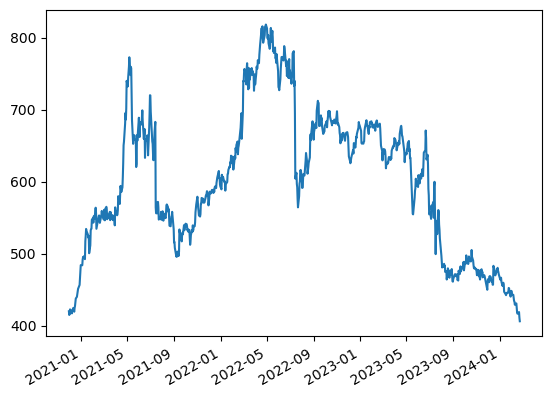

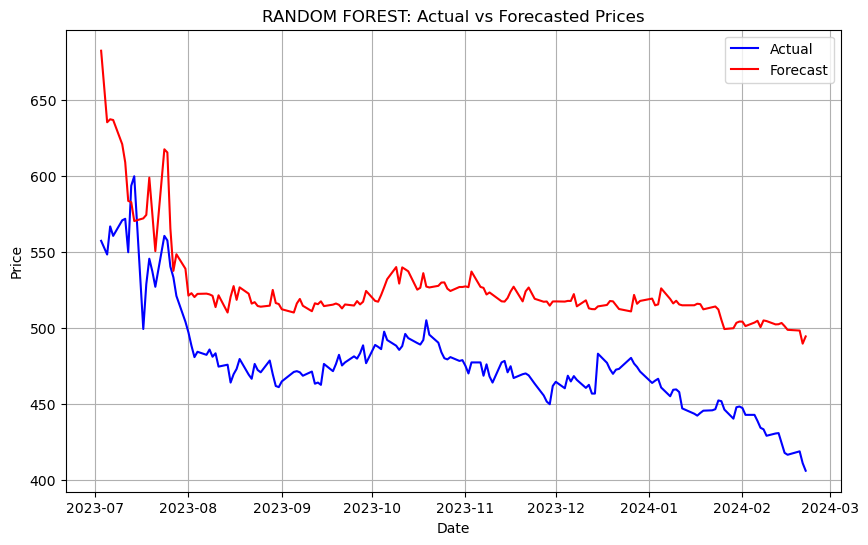

In [7]:
corn_model = random_forest_prediction(corn_code, corn_cities, corn_shift)

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_56351/32911149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date'] = pd.to_datetime(weather['date'])


Mean Squared Error (MSE): 116.25850738062069
 
         Feature  Importance
3      Last_Week    0.520424
5   Weekly_Trend    0.278175
4  Monthly_Trend    0.183003
1  CITY:CO000012    0.006938
0  CITY:BR000003    0.006373
2  CITY:ID000015    0.005086


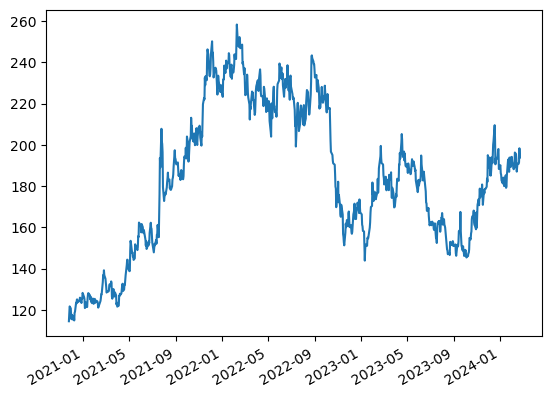

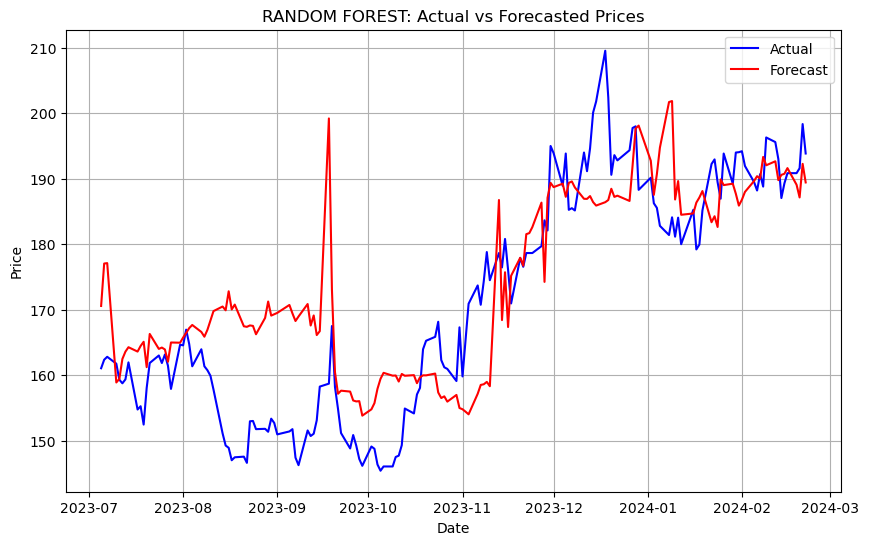

In [8]:
coffee_model = random_forest_prediction(coffee_code, coffee_cities, coffee_shift)

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_56351/32911149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date'] = pd.to_datetime(weather['date'])


Mean Squared Error (MSE): 11.95221605851368
 
         Feature  Importance
3      Last_Week    0.858094
5   Weekly_Trend    0.057656
4  Monthly_Trend    0.034904
0  CITY:CH000040    0.023363
2  CITY:US480005    0.017819
1  CITY:IN000021    0.008164


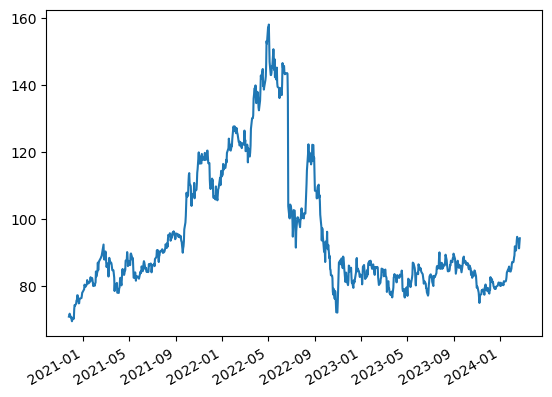

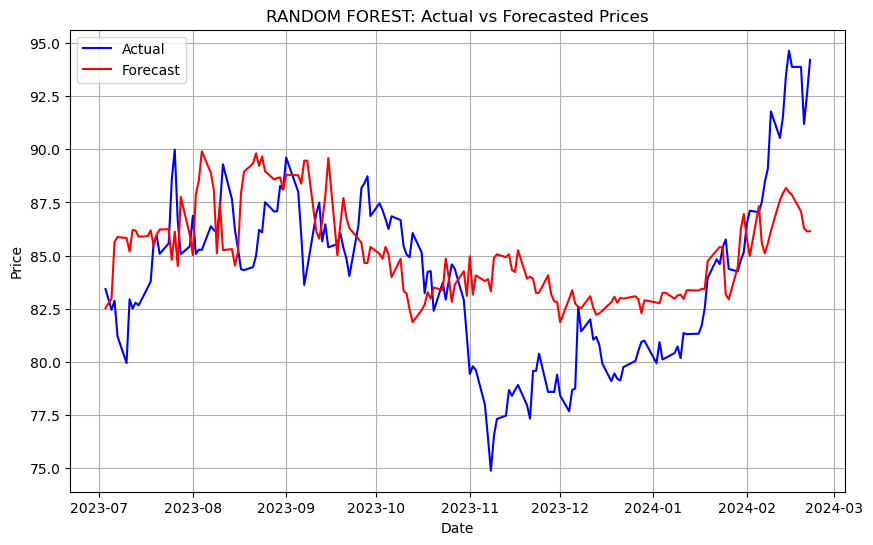

In [9]:
cotton_model = random_forest_prediction(cotton_code, cotton_cities, cotton_shift)

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_56351/32911149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date'] = pd.to_datetime(weather['date'])


Mean Squared Error (MSE): 3127.2254451111967
 
         Feature  Importance
2      Last_Week    0.714244
4   Weekly_Trend    0.170383
3  Monthly_Trend    0.065520
0  CITY:CH000014    0.026151
1  CITY:US170006    0.023701


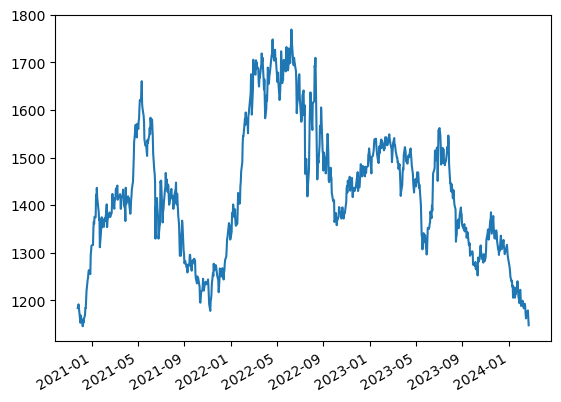

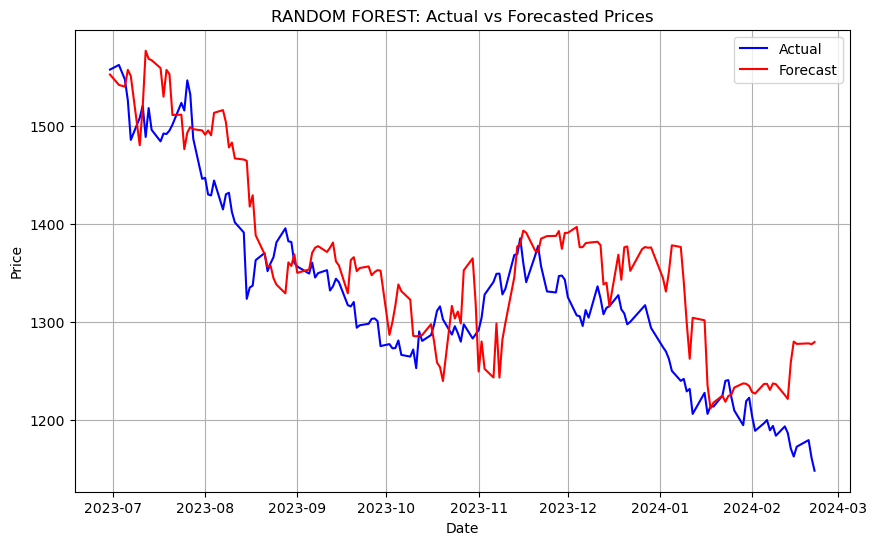

In [10]:
soybean_model = random_forest_prediction(soybean_code, soybean_cities, soybean_shift)

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_56351/32911149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['date'] = pd.to_datetime(weather['date'])


Mean Squared Error (MSE): 1965.3628442069278
 
         Feature  Importance
2      Last_Week    0.867234
3  Monthly_Trend    0.046286
4   Weekly_Trend    0.040221
0  CITY:CH000033    0.025592
1  CITY:FR000018    0.020667


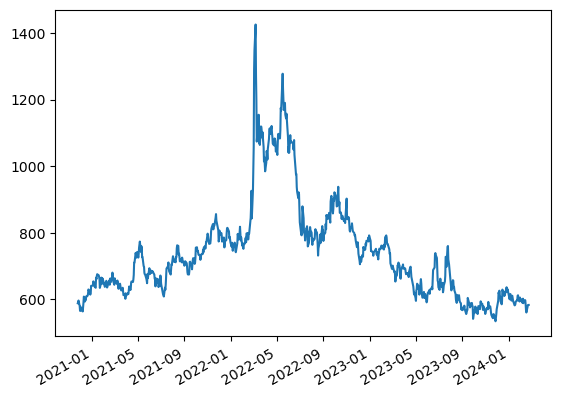

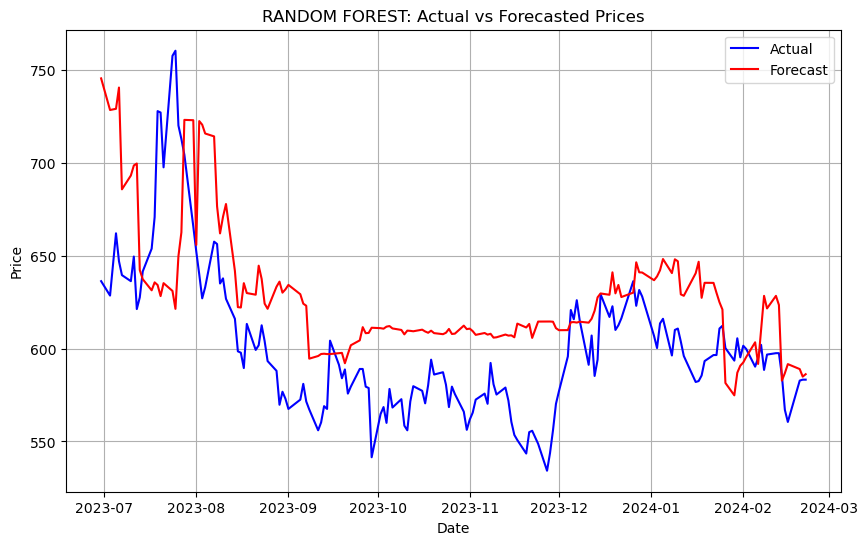

In [11]:
wheat_model = random_forest_prediction(wheat_code, wheat_cities, wheat_shift)

In [12]:
def get_weather_data(city, date):
    
    base_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
    token = 'GLuxJhDiHkzKFwCPoKryQNVSaQeeaTGT'  # Your NOAA API token
    
    headers = {'token': token}
    
    total = []
    
    param = "TAVG"
    year = 2023
    
    end_date = (date).strftime('%Y-%m-%d')
    start_date =(date).strftime('%Y-%m-%d')
    

    params = {
            'datasetid': 'GHCND',  # GHCND dataset contains weather data
            'datatypeid': param,  # Example additional parameters
            'limit': 1000,  # Limiting to 1000 results per request
            'locationid': city,  # FIPS code for United States
            'startdate': start_date,
            'enddate': end_date
            }
           
    response = requests.get(base_url, headers=headers, params=params)
    data = response.json()
    results = data.get('results', [])
    total.append(results)
    
    flat_data = [item for sublist in total for item in sublist]
    total_vf = pd.DataFrame(flat_data, columns=['date', 'datatype', 'value'])
    total_vf["city"] = city
    
    
    return total_vf

In [13]:
##### FUNCTION FOR SERVER TO GET LATEST PREDICTION DEPENDING ON THE COMMODITY

def prediction_commodity(commodity):
    
    if commodity == "corn":
        commodity_code = corn_code
        commodity_cities = corn_cities
        weather_shift = corn_shift
        model_to_use = corn_model
        
    elif commodity == "coffee":
        commodity_code = coffee_code
        commodity_cities = coffee_cities
        weather_shift = coffee_shift
        model_to_use = coffee_model
        
    elif commodity == "cotton":
        commodity_code = cotton_code
        commodity_cities = cotton_cities
        weather_shift = cotton_shift
        model_to_use = cotton_model
        
    elif commodity == "soybean":
        commodity_code = soybean_code
        commodity_cities = soybean_cities
        weather_shift = soybean_shift
        model_to_use = soybean_model
        
    elif commodity == "wheat":
        commodity_code = wheat_code
        commodity_cities = wheat_cities
        weather_shift = wheat_shift
        model_to_use = wheat_model
        
    else:
        return("Commodity not found. Predictions are available for corn, coffee, cotton, soybean and wheat.")
        
    end_date = (datetime.today().date()).strftime('%Y-%m-%d')
    start_date = (datetime.today().date() - pd.Timedelta(days=60)).strftime('%Y-%m-%d')

    commodity_data = get_commodity_data([commodity_code], start_date, end_date)
    commodity_data["Last_Week"] = commodity_data["Adj Close"].shift(7)
    commodity_data["Monthly_Trend"] = commodity_data["Last_Week"].rolling(window=30).mean()
    commodity_data["Weekly_Trend"] = commodity_data["Last_Week"].rolling(window=7).mean()
    
    ref_date = commodity_data.index[-1]

    to_predict = []

    for city in commodity_cities:
        to_predict.append(np.mean(get_weather_data(city,ref_date- pd.Timedelta(days=weather_shift))["value"]))
    
    to_predict.append(commodity_data["Last_Week"][-1])
    to_predict.append(commodity_data["Monthly_Trend"][-1])
    to_predict.append(commodity_data["Weekly_Trend"][-1])

    to_predict = pd.DataFrame(to_predict).transpose()
    
    result = {
    'Reference Date': ref_date.strftime('%Y-%m-%d'),
    'Observed': commodity_data["Adj Close"][-1],
    'Next Week Prediction': model_to_use.predict(to_predict)[0]
    }
    
    return result

In [ ]:
##### WE SET UP SERVER TO RECEIVE COMMODITY NAME AND SEND OBSERVED AND PREDICTED VALUES 
##### FOR CLIENT TO DECIDE NEXT ACTION

class MyTCPHandler(socketserver.BaseRequestHandler):
    """
    The request handler class for our server.
    It is instantiated once per connection to the server, and must
    override the handle() method to implement communication to the
    client.
    """

    def handle(self):
        # self.request is the TCP socket connected to the client
        self.data = self.request.recv(1024).strip()
        print("{} wrote:".format(self.client_address[0]))
        print(self.data)
        
        try:
            # Call your function with the received data
            result = prediction_commodity(self.data.decode('utf-8'))  # Assuming your function takes a string input
        
            # Convert the result dictionary to a JSON string
            result_json = json.dumps(result)
        
            # Send the result back to the client
            self.request.sendall(result_json.encode('utf-8'))
        except json.JSONDecodeError as e:
            # Handle JSONDecodeError gracefully
            error_message = {"error": "Invalid JSON format in response"}
            self.request.sendall(json.dumps(error_message).encode('utf-8'))

if __name__ == "__main__":
    HOST, PORT = "localhost", 9999

    # Create the server, binding to localhost on port 9999
    with socketserver.TCPServer((HOST, PORT), MyTCPHandler) as server:
        print("Server started on {}:{}".format(HOST, PORT))
        # Activate the server; this will keep running until you
        # interrupt the program with Ctrl-C
        server.serve_forever()


Server started on localhost:9999
127.0.0.1 wrote:
b'corn'
[*********************100%%**********************]  1 of 1 completed
127.0.0.1 wrote:
b'wheat'
[*********************100%%**********************]  1 of 1 completed

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



127.0.0.1 wrote:
b'soybean'
[*********************100%%**********************]  1 of 1 completed
127.0.0.1 wrote:
b'cotton'
[*********************100%%**********************]  1 of 1 completed

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


127.0.0.1 wrote:
b'coffee'
[*********************100%%**********************]  1 of 1 completed


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
